<a href="https://colab.research.google.com/github/agusresasco/Varios/blob/main/Spectrogram_analysis_Neuromatch_Academy_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music classification and generation with spectrograms

**By Neuromatch Academy**

__Content creators:__ Beatrix Benko, Lina Teichmann

**Modified by** Alessandra F. Latorre 
Agustina Resasco
Juan R. Castiñeiras
Leonardo Dalla Porta
Sebastián M. Geli
Nicolas Nieto



<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

## This notebook
This notebook loads the GTZAN dataset which includes audiofiles and spectrograms. You can use this dataset or find your own. The first part of the notebook is all about data visualization and show how to make spectrograms from audiofiles. The second part of the notebook includes a CNN that is trained on the spectrograms to predict music genre. Below we also provide links to tutorials and other resources if you want to try to do some of the harder project ideas. 

Have fun :) 


## Acknowledgements
This notebook was written by Beatrix Benkő and Lina Teichmann.

**Useful code examples:** 

https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8

[https://pytorch.org/vision/stable/models.html](https://pytorch.org/vision/stable/models.html)

[https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py)

https://github.com/kamalesh0406/Audio-Classification 

https://github.com/zcaceres/spec_augment

https://musicinformationretrieval.com/ipython_audio.html 

---
# Setup

In [ ]:
# @title Install dependencies
!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
     |████████████████████████████████| 26.9 MB 82.3 MB/s 


In [ ]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
import copy

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [ ]:
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

# **RANDOM SEED**

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
SEED = 2022
set_seed(seed=SEED)


Random seed 2022 has been set.


## Loading GTZAN dataset (includes spectrograms)

The GTZAN dataset for music genre classification can be dowloaded from Kaggle: https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification. 

To download from Kaggle using this code you need to download and copy over your api token. In Kaggle go to the upper right side -> account -> API -> create API token. This downloads a json file. Copy the content into api_token. It should look like this: 

api_token = {"username":"johnsmith","key":"123a123a123"}


In [ ]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

## Have a look at the data

In this section we are looking at an example of an audio waveform. Then we'll transform the sound wave to a spectrogram and compare it with the spectrogram that was included with the downloaded dataset.

In [ ]:
# Inspect an audio file from the dataset.

sample_path = 'Data/genres_original/jazz/jazz.00000.wav'

# if you want to listen to the audio, uncomment below.
display.Audio(sample_path)

y: [-0.00924683 -0.01177979 -0.01370239 ...  0.0071106   0.00561523
  0.00561523] 

y shape: (661794,) 

Sample rate (Hz): 22050 

Length of audio: 30.013333333333332s


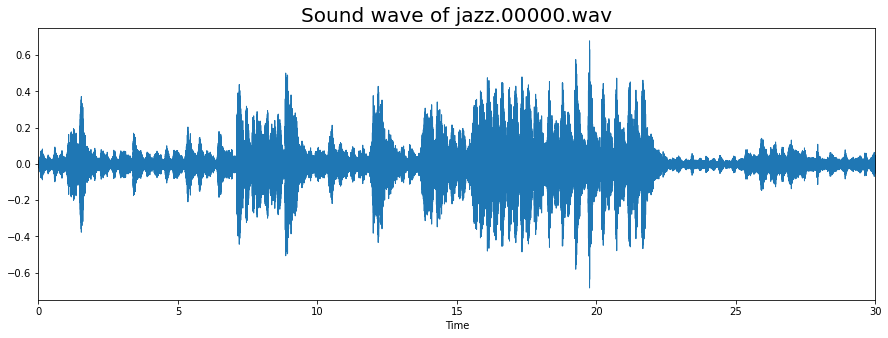

In [ ]:
y, sample_rate = librosa.load(sample_path)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample rate (Hz):', sample_rate, '\n') 
print(f'Length of audio: {np.shape(y)[0]/sample_rate}s')

# Plot th sound wave.

plt.figure(figsize=(15, 5))
librosa.display.waveplot(y=y, sr=sample_rate);
plt.title("Sound wave of jazz.00000.wav", fontsize=20)
plt.show()

Shape of D object: (1025, 1293)


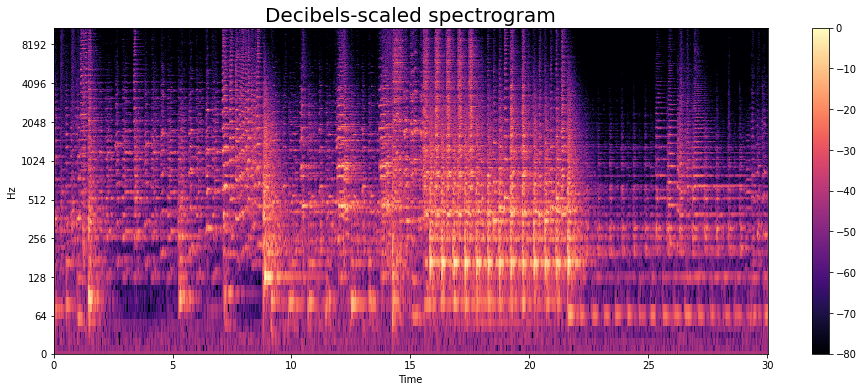

In [ ]:
# Convert sound wave to spectrogram.

# Short-time Fourier transform (STFT).

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))  # Tamaño de la ventana y salto entre ventanas
print('Shape of D object:', np.shape(D))

# Convert amplitude spectrogram to Decibels-scaled spectrogram.

DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the spectogram.

plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr=sample_rate, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Decibels-scaled spectrogram', fontsize=20)
plt.show()

The mel spectrogram uses mel sclae intead of a linear one: [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments. 

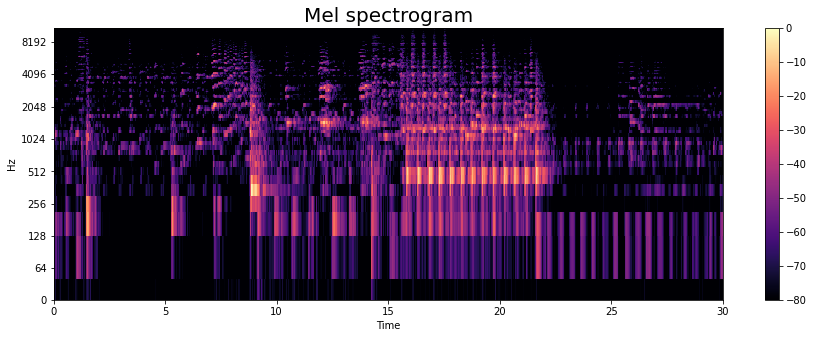

In [ ]:
# Convert sound wave to mel spectrogram.

y, sr = librosa.load(sample_path)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_DB, sr=sr, hop_length=512,
                         x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Mel spectrogram", fontsize=20)
plt.show()

In [ ]:
L = librosa.feature.inverse.mel_to_stft(S)
T = librosa.griffinlim(L)
display.Audio(data=T, rate=sr)

(288, 432, 4)


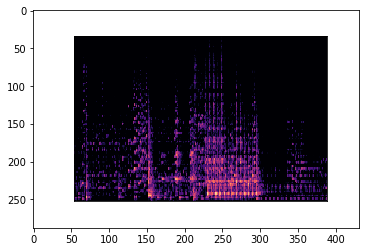

In [ ]:
# Visualize the mel spectrogram of the same sample from the dataset.

img_path = 'Data/images_original/jazz/jazz00000.png'
img = imageio.imread(img_path)
print(img.shape)

plt.imshow(img, interpolation='nearest')
plt.show()

## Train a simple CNN 

In [ ]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

In [ ]:
device = set_device()

GPU is enabled in this notebook.


In [ ]:
# Create folder with training, testing and validation data.

spectrograms_dir = "Data/images_original/"
folder_names = ['Data/train/', 'Data/test/', 'Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]
  val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [ ]:
# Data loading.
set_seed(SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)
# TRAIN
train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(scale=(0.02,0.2)),
        transforms.RandomAutocontrast(),
        transforms.RandomAdjustSharpness(sharpness_factor=2)
        # transforms.RandomEqualize(),
        # transforms.RandomPosterize(bits=2),
        # transforms.Grayscale(3)
    ]))

#crop
train_dataset = [(transforms.functional.crop(img[0], 35, 53, 218, 336),img[1]) for img in train_dataset]# tamaño original 288, 432

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0, generator=g_seed)

# VALIDATION
val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor()
        # transforms.Grayscale(3)
    ]))

#crop
val_dataset = [(transforms.functional.crop(img[0], 35, 53, 218, 336),img[1]) for img in val_dataset]# tamaño original 288, 432

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0, generator=g_seed)


ntest = np.size(os.listdir(test_dir+genres[0]))
ngen  = np.size(genres)

# TEST
test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
        # transforms.Grayscale(3),
    ]))

test_dataset = [(transforms.functional.crop(img[0], 35, 53, 218, 336),img[1]) for img in test_dataset]# tamaño original 288, 432

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=ntest*ngen, shuffle=False, num_workers=0, generator=g_seed)

Random seed 2022 has been set.


In [ ]:
# Make a CNN & train it to predict genres.

class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
    # self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    # self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)
    n_out_fc1= 512 #2048
    self.fc1 = nn.Linear(in_features=145152, out_features=n_out_fc1)
    # self.fc1 = nn.Linear(in_features=7680, out_features=n_out_fc1)
    self.fc2 = nn.Linear(in_features=n_out_fc1, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)
    # self.batchnorm6 = nn.BatchNorm2d(num_features=256)

    self.dropout1 = nn.Dropout(p=0.4, inplace=False)
    self.dropout2 = nn.Dropout(p=0.35, inplace=False)
    self.dropout3 = nn.Dropout(p=0.25, inplace=False)
    self.dropout4 = nn.Dropout(p=0.5, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    # x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    # x = F.max_pool2d(x, kernel_size=2)
    x = self.dropout1(x)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.dropout2(x)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.dropout3(x)

    # # Conv layer 6.
    # x = self.conv6(x)
    # x = self.batchnorm6(x)
    # x = F.relu(x)
    # x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = torch.flatten(x, 1)   
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout4(x)

    # Fully connected layer 2
    x = self.fc2(x)

    return x


def l2_reg(model):
  l2 = 0.0
  for param in model.parameters():
    l2 += torch.sum(torch.abs(param)**2)

  return l2

def l1_reg(model):
  l1 = 0.0
  for param in model.parameters():
    l1 += torch.sum(torch.abs(param))

  return l1

def train(model, device, train_loader, validation_loader, epochs, learning_rate,lambdareg,alpha, patience):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  best_acc = 0.0
  best_epoch = 0

  # Keeps track of number of epochs during which the val_acc was less than best_acc
  wait = 0

  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        # loss  = criterion(output, target)
        loss  = criterion(output, target) + lambdareg*(alpha*l1_reg(model) + (1-alpha)*l2_reg(model))
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += torch.sum((predicted == target)).item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0


      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      val_acc = correct/total
      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(val_acc)

      if (val_acc > best_acc):
        best_acc = val_acc
        best_epoch = epoch
        best_model = copy.deepcopy(model)
        wait = 0
        print('Best val. acc. so far: ', best_acc, '. Epoch:', epoch)
      else:
        wait += 1

      if (wait > patience):
        print(f'Early stopped on epoch: {epoch}')
        print(wait)
        print(patience)
        break
     

  return train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch

In [ ]:
# Run training.
set_seed(SEED)
net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 175, 0.0001, 0.002, .25)
# plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
print('Max validation accuracy = ',np.max(validation_acc))

Random seed 2022 has been set.


TypeError: ignored

In [ ]:
train_loss_np = [i.detach().cpu().numpy() for i in train_loss]
plot_loss_accuracy(train_loss_np, train_acc, validation_loss, validation_acc)

In [ ]:
print('armando el notebook')


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


In [ ]:
test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=0)
for data, target in test_loader:
        # getting the training set
    data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
    output = net(data)


importar sklearn

In [ ]:
truelabels = []
predictions = []
for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      for label in target.data:
        truelabels.append(label.item())
      for prediction in net(data).argmax(1):
        predictions.append(prediction.item())

In [ ]:
# get all the test examples where the classification failed
for i, p in enumerate(predictions):
  if (i%20)==0:
      filelist = sorted(os.listdir(test_dir+genres[truelabels[i]]))
  if p != truelabels[i]:
    print(genres[truelabels[i]],genres[p],filelist[i%20])

In [ ]:
# # Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)

classes = genres

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted", fontsize = 14)
plt.ylabel("True", fontsize = 14)
plt.show()

matriz de géneros

# **Transfer Learning: Fine-tuning ResNet**

In [ ]:
#@title Data loading

g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5),
    ]))

train_dataset = [(transforms.functional.crop(img[0], 35, 53, 218, 336),img[1]) for img in train_dataset]# tamaño original 288, 432

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(), 
    ]))

val_dataset = [(transforms.functional.crop(img[0], 35, 53, 218, 336),img[1]) for img in val_dataset]# tamaño original 288, 432

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)

# **DATA AUGMENTATION**

Descomentar para correr

In [ ]:
# # Data loading.

# g_seed = torch.Generator()
# g_seed.manual_seed(SEED)

# train_dataset1 = datasets.ImageFolder(
#     train_dir,
#     transforms.Compose([
#         transforms.ToTensor(),
#         #transforms.Grayscale(1), #Convertir a byn
#         transforms.RandomErasing(p = 0.99, scale = (0.02, 0.9)),
#         #transforms.RandomEqualize(),
#         transforms.RandomAutocontrast(),
#         transforms.RandomAdjustSharpness(sharpness_factor=2),
#         #transforms.RandomPosterize(bits=2)
#     ]))


# train_dataset2 = datasets.ImageFolder(
#     train_dir,
#     transforms.Compose([
#         transforms.ToTensor(),
#     ]))

# #Notar que en la lista por comprension hago una tupla para mantener el formato
# train_dataset1 = [(transforms.functional.crop(img[0], 35, 53, 218, 336),img[1]) for img in train_dataset1]# tamaño original 288, 432#
# train_dataset2 = [(transforms.functional.crop(img[0], 35, 53, 218, 336),img[1]) for img in train_dataset2]# tamaño original 288, 432

# train_dataset = train_dataset1 + train_dataset2

# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=25, shuffle=True, num_workers=0)

# val_dataset = datasets.ImageFolder(
#     val_dir,
#     transforms.Compose([
#         transforms.ToTensor(),
#         #transforms.Grayscale(1) #Convertir a byn
#         ]))

# val_dataset = [(transforms.functional.crop(img[0], 35, 53, 218, 336),img[1]) for img in val_dataset]# tamaño original 288, 432


# val_loader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=25, shuffle=True, num_workers=0)

In [ ]:
# import torchvision
# import tqdm
# import IPython

# resnet = torchvision.models.resnet18(pretrained=True)
# num_ftrs = resnet.fc.in_features
# # Reset final fully connected layer, number of classes = 10
# resnet.fc = nn.Linear(num_ftrs, 10)
# resnet.to(device)
# optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
# loss_fn = nn.CrossEntropyLoss()

In [ ]:
# pretrained_accs = []
# for epoch in tqdm.tqdm(range(50)):
#   # Train loop
#   for batch in train_loader:
#     images, labels = batch
#     images = images.to(device)
#     labels = labels.to(device)

#     optimizer.zero_grad()
#     output = resnet(images)
#     loss = loss_fn(output, labels)
#     loss.backward()
#     optimizer.step()

#   # Eval loop
#   with torch.no_grad():
#     loss_sum = 0
#     total_correct = 0
#     total = len(val_dataset)
#     for batch in val_loader:
#       images, labels = batch
#       images = images.to(device)
#       labels = labels.to(device)
#       output = resnet(images)
#       loss = loss_fn(output, labels)
#       loss_sum += loss.item()

#       predictions = torch.argmax(output, dim=1)

#       num_correct = torch.sum(predictions == labels)
#       total_correct += num_correct

#     # Plot accuracy
#     pretrained_accs.append(total_correct.cpu() / total)
#     plt.plot(pretrained_accs)
#     plt.xlabel('epoch')
#     plt.ylabel('accuracy')
#     plt.title('Music genres prediction accuracy')
#     IPython.display.clear_output(wait=True)
#     IPython.display.display(plt.gcf())
#   plt.close()

**Train resnet**

In [ ]:
import torchvision
from tqdm.notebook import tqdm
import IPython

# Run training.
set_seed(SEED)
net = torchvision.models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
# Reset final fully connected layer, number of classes = 10
net.fc = nn.Linear(num_ftrs, 10)
# print(resnet)
net.to(device)
train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch = train(net, device, train_loader, val_loader, 100, 0.0001, 0.0000, .5, 20)
print('Max validation accuracy = ',np.max(validation_acc))
net = best_model

Random seed 2022 has been set.


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/100 [00:00<?, ?epoch/s]

Best val. acc. so far:  0.63 . Epoch: 0
Best val. acc. so far:  0.78 . Epoch: 1
Best val. acc. so far:  0.79 . Epoch: 4
Best val. acc. so far:  0.81 . Epoch: 10


In [ ]:
net.eval()
for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      truelabels = target.detach().cpu().numpy()
      predictions = net(data).argmax(dim=1).detach().cpu().numpy()
      
# COMPARANDO CON EL TEST DATASET

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))


test_dataset = [(transforms.functional.crop(img[0], 35, 53, 218, 336),img[1]) for img in test_dataset]# tamaño original 288, 432


test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=0)

net.eval()
for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      truelabels = target.detach().cpu().numpy()
      predictions = net(data).argmax(dim=1).detach().cpu().numpy()

accuracy = np.sum((truelabels == predictions))/len(truelabels)

print(accuracy)

# **ADD DROPOUT INTO RESNET**

In [ ]:
# INSERT DROPOUT INTO RESNET

# layers = list(net.named_children())
# print(len(layers))
# print(layers[9])
# print(net)

net = torchvision.models.resnet18(pretrained=True)

# modify the network

do_rate = 0.5 #dropout rate
def append_dropout(model, count=0,rate=do_rate):
    for name, module in model.named_children():
      if name == 'layer4': #add dropout only in layer 4
        count = 1
      if len(list(module.children())) > 0:
        append_dropout(module,count)
      if count == 1:
        if isinstance(module, nn.ReLU):
          new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
          setattr(model, name, new)
      elif count == 0: #freeze params before layer 4
        for param in module.parameters():
          param.requires_grad = False


append_dropout(net)
# print(net)

num_ftrs = net.fc.in_features 
# Reset final fully connected layer
n_hidden = 128 # output size of hidden layer
net.fc = nn.Linear(num_ftrs, n_hidden)
# add a dropout and another fully connected layer
new = nn.Sequential(net.fc, nn.Dropout(p=do_rate, inplace=False), nn.Linear(n_hidden, 10))
setattr(net, 'fc', new)

# new forward method
def new_forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    
    x = self.avgpool(x).permute([0,2,3,1])
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

# redefine the old forward as the new
bound_method = new_forward.__get__(net, net.__class__)
setattr(net, 'forward', bound_method)

# testing the sizes
# call the new forward method
inputs = torch.rand(25, 3, 224, 224)
outputs = net(inputs)

print('type(resent) = ', type(net))
print('type(resent.forward) = ', type(net.forward))
print('outputs.shape = ', outputs.shape)
print(net)

# SPECTOGRAMS IN 3 CHANNELS (BY LEO)

In [ ]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
plt.figure(figsize=(218px, 336px))

# num_channels = 1
# window_sizes = 25
# hop_sizes = 10

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

for g in genres:
    pathlib.Path(f'Data/genres_original/images_new/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'{data_path}/{g}'):
          songname = f'{data_path}{g}/{filename}'
          # print(songname)
          clip, sr = librosa.load(songname)
          clip = torch.Tensor(clip)

          num_channels = 3
          window_sizes = [25, 50, 100]
          hop_sizes = [10, 25, 50]

          for i in range(num_channels):
            window_length = int(round(window_sizes[i]sr/1000))
            hop_length = int(round(hop_sizes[i]sr/1000))

            eps = 1e-6
            spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=2205, win_length=window_length, hop_length=hop_length, n_mels=128)(clip) #Check this otherwise use 2400
            spec = spec.numpy()
            spec = np.log(spec+eps)
            spec = np.asarray(torchvision.transforms.Resize((128, 1500))(Image.fromarray(spec)))
            plt.imshow(spec)
            plt.axis('off')
            plt.savefig(f'Data/genres_original/imagesnew/{g}/{filename[:-3].replace(".", "")}{i}_.png', bbox_inches='tight',pad_inches = 0)
            plt.clf()